In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import svm
import pyswarms as ps

import wta, ic

import os
import math

In [3]:
data_dir = '../data/planetlab'
# smooth_csv = ('20110303', 'ait05_us_es_root')
smooth_csv = ('20110306', 'planetlab1_cs_purdue_edu_purdue_2')
trend_csv = ('20110412', 'planet1_scs_cs_nyu_edu_uw_oneswarm')
period_csv = ('20110403', 'planetlab2-santiago_lan_redclara_net_ethzcs_tracegatherer')

smooth_df = pd.read_csv(os.path.join(data_dir, *smooth_csv))
trend_df = pd.read_csv(os.path.join(data_dir, *trend_csv))
period_df = pd.read_csv(os.path.join(data_dir, *period_csv))

In [4]:
smooth_ts, trend_ts, period_ts = wta.pre(smooth_df, trend_df, period_df)

In [8]:
smooth_wl_type, smooth_period = wta.workload_aware(smooth_ts)
trend_wl_type, trend_period = wta.workload_aware(trend_ts)
period_wl_type, period = wta.workload_aware(period_ts)
smooth_wl_type, trend_wl_type, (period_wl_type, period)

('SMOOTH', 'TREND', ('PERIOD', 47))

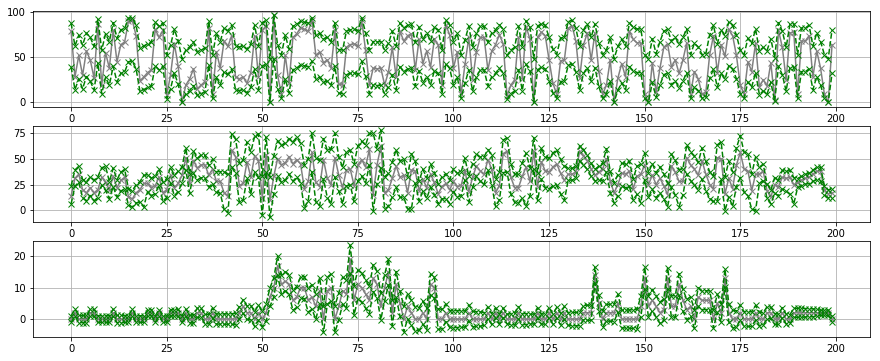

In [11]:
smooth_ts_up, smooth_ts_low = ic.ic(smooth_ts, smooth_wl_type)
trend_ts_up, trend_ts_low = ic.ic(trend_ts, trend_wl_type)
period_ts_up, period_ts_low = ic.ic(period_ts, period_wl_type, period)

st, ed = 50, 250
plt.figure(figsize=(15,6))
plt.subplot(311)
origin1 = smooth_ts[st:ed]
origin1.index = range(len(origin1))
plt.plot(origin1, color='gray', marker='x')
plt.grid()
plt.plot(smooth_ts_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(smooth_ts_low[st:ed], linestyle='--', color='green', marker='x')

plt.subplot(312)
origin2 = trend_ts[st:ed]
origin2.index = range(len(origin2))
plt.plot(origin2, color='gray', marker='x')
plt.grid()
plt.plot(trend_ts_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(trend_ts_low[st:ed], linestyle='--', color='green', marker='x')

plt.subplot(313)
origin3 = period_ts[st:ed]
origin3.index = range(len(origin3))
plt.plot(origin3, color='gray', marker='x')
plt.grid()
plt.plot(period_ts_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(period_ts_low[st:ed], linestyle='--', color='green', marker='x')

In [13]:
# 样本集大小
smooth_ts_up.shape, smooth_ts_low.shape, trend_ts_up.shape, trend_ts_low.shape,period_ts_up.shape, period_ts_low.shape

((287,), (287,), (287,), (287,), (287,), (287,))

In [446]:
sample_size = 287

train_size = 200
x_size = 4
# train_test_split for smooth_ts_up and smooth_ts_low
smu_train, smu_test = smooth_ts_up[:train_size], smooth_ts_up[train_size:]
sml_train, sml_test = smooth_ts_low[:train_size], smooth_ts_low[train_size:]

# train_test_split for trend_ts_up and trend_ts_low
tru_train, tru_test = trend_ts_up[:train_size], trend_ts_up[train_size:]
trl_train, trl_test = trend_ts_low[:train_size], trend_ts_low[train_size:]

# train_test_split for period_ts_up and period_ts_low
peu_train, peu_test = period_ts_up[:train_size], period_ts_up[train_size:]
pel_train, pel_test = period_ts_low[:train_size], period_ts_low[train_size:]

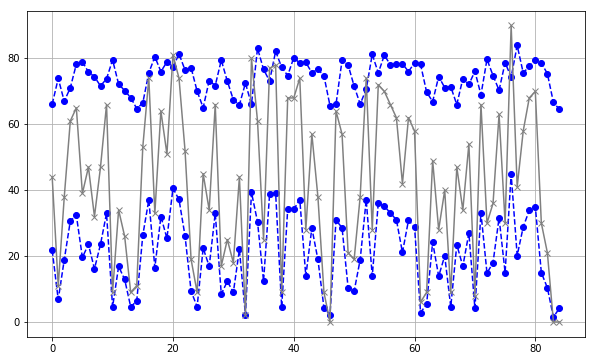

In [480]:
def split_to_xy(ts, d=range(1,4)):
    """将原时序数据转变为x,y两个数列,
    x（向量，每个分量x[i]滞后期为d[i]）作为svm回归的自变量
    """
    x=np.empty((0,len(d)))
    y = np.array([])
    for i in range(len(ts)):
        # 相应滞后的值在原序列中的索引
        idx = []
        for j in d:
            k = i - j
            if k >= 0:
                idx.append(k)
            else:
                idx = []
                break;
        x_d = []
        for j in idx:
            x_d.append(ts[j])
        if len(x_d) != 0:
            x_d = np.array([x_d])
            x = np.row_stack((x, x_d))
            y = np.append(y, ts[i])
    return x, y

# 滞后期数列 d>1 因为不能用当前点预测当前点
# svm gamma取值范围[0.0001, 1] C取值范围[1,30]，这个范围之后用在
diff = 3
xu_tr, yu_tr = split_to_xy(smu_train, d=range(1,diff))
xu_te, yu_te = split_to_xy(smu_test, d=range(1,diff))
svru = svm.SVR(gamma=0.001, C=10)
svru.fit(xu_tr, yu_tr)
pu = svru.predict(xu_te)

plt.figure(figsize=(10,6))
# plt.subplot(121)
plt.plot(pu, color='blue', marker='o', linestyle='--')
# plt.subplot(122)
# plt.plot(yu_te, color='gray', linestyle='--')

xl_tr, yl_tr = split_to_xy(sml_train, d=range(diff))
xl_te, yl_te = split_to_xy(sml_test, d=range(diff))
svrl = svm.SVR(gamma=0.001, C=20)
svrl.fit(xl_tr, yl_tr)
pl = svrl.predict(xl_te)
# plt.subplot(122)
plt.plot(pl, color='blue', marker='o', linestyle='--')
# train_size比pl长的原因是，我们将sml_test作为一个全新的时序数据，那么差分的时候，前diff-1个值是预测不了的，因为不存在序号为-1，-2
tmp = smooth_ts[train_size+diff-1:]
tmp.index = range(len(tmp))
plt.plot(tmp, color='gray', marker='x')
plt.grid()

In [482]:
pl.shape, pu.shape, len(tmp)

((85,), (85,), 85)

In [483]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
print(mean_absolute_error(yu_te, pu), mean_squared_error(yu_te, pu), r2_score(pu, yu_te))
print(mean_absolute_error(yl_te, pl), mean_squared_error(yl_te, pl), r2_score(pl, yl_te))

9.071062284989196 141.13846626750578 -0.13005529149744444
7.905866147486095 92.2733542605777 -1.0070679256121755


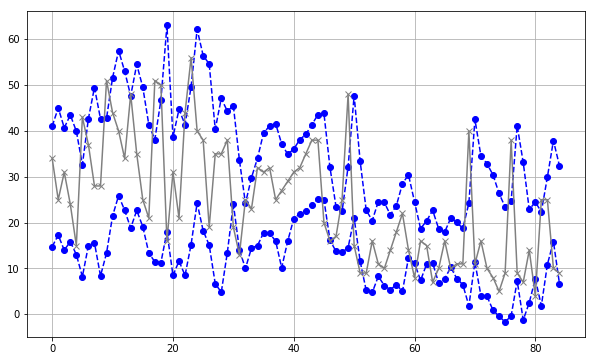

In [481]:
# 滞后期数列 d>1 因为不能用当前点预测当前点
# svm gamma取值范围[0.0001, 1] C取值范围[1,30]，这个范围之后用在
diff = 3
xu_tr, yu_tr = split_to_xy(tru_train, d=range(1,diff))
xu_te, yu_te = split_to_xy(tru_test, d=range(1,diff))
svru = svm.SVR(gamma=0.001, C=30)
svru.fit(xu_tr, yu_tr)
pu = svru.predict(xu_te)

plt.figure(figsize=(10,6))
# plt.subplot(121)
plt.plot(pu, color='blue', marker='o', linestyle='--')
# plt.subplot(122)
# plt.plot(yu_te, color='gray', linestyle='--')

xl_tr, yl_tr = split_to_xy(trl_train, d=range(1,diff))
xl_te, yl_te = split_to_xy(trl_test, d=range(1,diff))
svrl = svm.SVR(gamma=0.001, C=20)
svrl.fit(xl_tr, yl_tr)
pl = svrl.predict(xl_te)
# plt.subplot(122)
plt.plot(pl, color='blue', marker='o', linestyle='--')
tmp = trend_ts[train_size+diff-1:]
tmp.index = range(len(tmp))
plt.plot(tmp, color='gray', marker='x')
plt.grid()

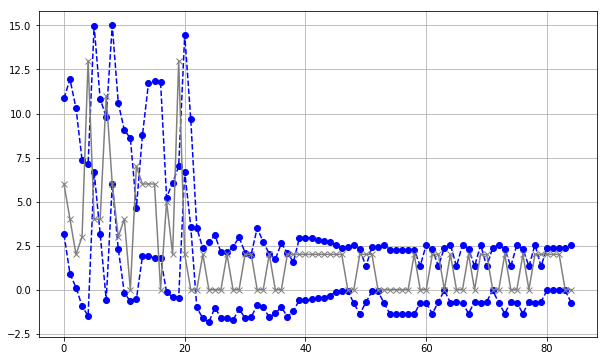

In [477]:
# 滞后期数列 d>1 因为不能用当前点预测当前点
# svm gamma取值范围[0.0001, 1] C取值范围[1,30]，这个范围之后用在
diff=3
xu_tr, yu_tr = split_to_xy(peu_train, d=range(1,diff))
xu_te, yu_te = split_to_xy(peu_test, d=range(1,diff))
svru = svm.SVR(gamma=0.01, C=20)
svru.fit(xu_tr, yu_tr)
pu = svru.predict(xu_te)

plt.figure(figsize=(10,6))
# plt.subplot(121)
plt.plot(pu, color='blue', marker='o', linestyle='--')
# plt.subplot(122)
# plt.plot(yu_te, color='gray', linestyle='--')

xl_tr, yl_tr = split_to_xy(pel_train, d=range(1,diff))
xl_te, yl_te = split_to_xy(pel_test, d=range(1,diff))
svrl = svm.SVR(gamma=0.01, C=20)
svrl.fit(xl_tr, yl_tr)
pl = svrl.predict(xl_te)
# plt.subplot(122)
plt.plot(pl, color='blue', marker='o', linestyle='--')
tmp = period_ts[train_size+diff-1:]
tmp.index = range(len(tmp))
plt.plot(tmp, color='gray', marker='x')
plt.grid()

In [444]:
pl.shape, pu.shape, len(tmp)

((85,), (85,), 85)

In [365]:
# ARIMA做法
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
#Perform Dickey-Fuller test:
def static_test(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
static_test(smu_train)
static_test(smu_test)

Results of Dickey-Fuller Test:
Test Statistic                -1.201290e+01
p-value                        3.150558e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.990000e+02
Critical Value (1%)           -3.463645e+00
Critical Value (5%)           -2.876176e+00
Critical Value (10%)          -2.574572e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -5.577877
p-value                         0.000001
#Lags Used                      9.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


Test MSE: 185.504


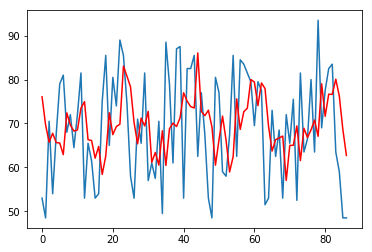

In [338]:
history = [x for x in smu_train]
predictions = list()
for t in range(len(smu_test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = smu_test[t]
	history.append(obs)
error = mean_squared_error(smu_test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(smu_test)
plt.plot(predictions, color='red')
plt.show()

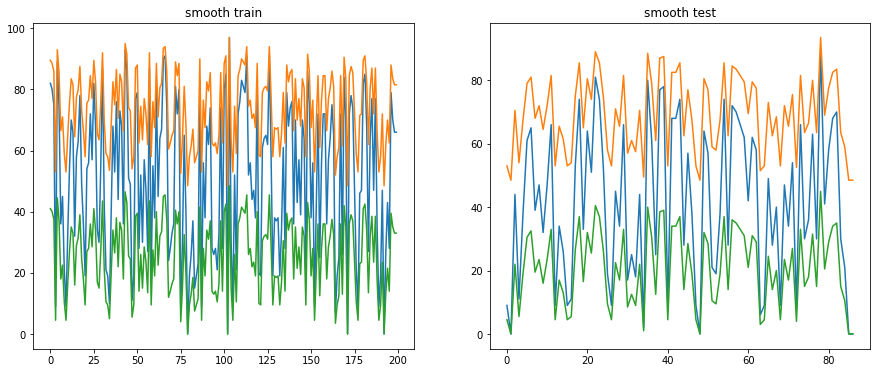

In [84]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('smooth train')
plt.plot(smooth_ts[:train_size])
plt.plot(smooth_ts_up[x_sml_train])
plt.plot(smooth_ts_low[x_sml_train])
plt.subplot(122)
plt.title('smooth test')
smu_test = smooth_ts[train_size:]
smu_test.index = range(len(smu_test))
plt.plot(smu_test)
plt.plot(smooth_ts_up[x_sml_test])
plt.plot(smooth_ts_low[x_sml_test])

In [16]:
def cwc(C_u, gamma_u, C_l, gamma_l, xu, yu, xl, yl):
    svr_u = svm.SVR(kernel='rbf', gamma=gamma_u, C=C_u)
    svr_l = svm.SVR(kernel='rbf', gamma=gamma_l, C=C_l)
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(xu):
        xu_train, xu_test = xu[train_index], xu[train_index]
        yu_train, yu_test = yu[test_index], yu[test_index]
        svr_u.fit(xu_train, yu_train)
        yu_p = svr_u.predict(xu_test)
        
        xl_train, xl_test = xl[train_index], xl[train_index]
        yl_train, yl_test = yl[test_index], yl[test_index]
        svr_u.fit(xl_train, yl_train)
        yl_p = svr_u.predict(xl_test)
    


array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [61]:
arr = np.arange(20)
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(arr):
    print(train_index, test_index)

[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0 1 2 3]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19] [4 5 6 7]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19] [ 8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19] [12 13 14 15]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [16 17 18 19]
